In [1]:
# CELL 1: Setup
import pandas as pd
from pathlib import Path
import nibabel as nib
import numpy as np
from scipy.ndimage import label, center_of_mass

CSV_FILE = Path('/user_data/csimmon2/git_repos/long_pt/long_pt_sub_info.csv')
df = pd.read_csv(CSV_FILE)

BASE_DIR = Path("/user_data/csimmon2/long_pt")
SESSION_START = {'sub-010': 2, 'sub-018': 2, 'sub-068': 2}

'''
COPE_MAP = {
    'face':   (10, 1),
    'word':   (13, -1),
    'object': (3,  1),
    'house':  (11, 1)
}
'''

# temp:

COPE_MAP = {
    'face': (10, 1),   # Face > Scramble
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

In [2]:
# CELL 2: Load Subjects
def load_subjects_by_group(group_filter=None, patient_only=True):
    filtered_df = df.copy()
    
    if patient_only is True:
        filtered_df = filtered_df[filtered_df['patient'] == 1]
    elif patient_only is False:
        filtered_df = filtered_df[filtered_df['patient'] == 0]
    
    if group_filter:
        if isinstance(group_filter, str):
            group_filter = [group_filter]
        filtered_df = filtered_df[filtered_df['group'].isin(group_filter)]
    
    subjects = {}
    for _, row in filtered_df.iterrows():
        subject_id = row['sub']
        subj_dir = BASE_DIR / subject_id
        if not subj_dir.exists():
            continue
        
        sessions = sorted([d.name.replace('ses-', '') for d in subj_dir.glob('ses-*') if d.is_dir()], key=int)
        start_session = SESSION_START.get(subject_id, 1)
        sessions = [s for s in sessions if int(s) >= start_session]
        if not sessions:
            continue
        
        hemisphere = 'l' if row.get('intact_hemi', 'left') == 'left' else 'r'
        
        subjects[subject_id] = {
            'code': f"{row['group']}{subject_id.split('-')[1]}",
            'sessions': sessions,
            'hemi': hemisphere,
            'group': row['group'],
            'patient_status': 'patient' if row['patient'] == 1 else 'control',
            'surgery_side': row.get('SurgerySide', None)
        }
    return subjects

ALL_PATIENTS = load_subjects_by_group(patient_only=True)
ALL_CONTROLS = load_subjects_by_group(patient_only=False)
ANALYSIS_SUBJECTS = {**ALL_PATIENTS, **ALL_CONTROLS}

In [3]:
# CELL 3: ROI Extraction Function
def extract_functional_rois_bilateral(subject_id, threshold_z=2.3, min_cluster_size=30):
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): 
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in COPE_MAP.items():
            cope_num, multiplier = cope_params
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): 
                continue
            
            try:
                search_mask = nib.load(mask_file).get_fdata() > 0
                affine = nib.load(mask_file).affine
            except: 
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): 
                    continue
                
                try:
                    zstat = nib.load(cope_file).get_fdata() * multiplier
                    suprathresh = (zstat > threshold_z) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    if n_clusters == 0: 
                        continue
                    
                    best_idx, max_peak = -1, -999
                    for i in range(1, n_clusters + 1):
                        cluster_mask = (labeled == i)
                        if np.sum(cluster_mask) >= min_cluster_size:
                            peak_val = np.max(zstat[cluster_mask])
                            if peak_val > max_peak:
                                max_peak, best_idx = peak_val, i
                    
                    if best_idx == -1: 
                        continue
                    
                    roi_mask = (labeled == best_idx)
                    peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': zstat[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask
                    }
                except Exception as e: 
                    print(f"Err {subject_id} {category}: {e}")
    return all_results

In [13]:
# CELL 3_v2: Top 20% ROI Extraction (Dynamic Thresholding)
import numpy as np
import nibabel as nib
from scipy.ndimage import label, center_of_mass

def extract_top_percentile_rois(subject_id, percentile=80, min_cluster_size=10):
    """
    Extracts ROI based on top Nth percentile of voxels within the search mask.
    This normalizes for global signal fluctuations across sessions.
    """
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists(): return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in COPE_MAP.items():
            cope_num, multiplier = cope_params
            
            # 1. Load Search Mask
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists(): continue
            
            try:
                search_mask_img = nib.load(mask_file)
                search_mask = search_mask_img.get_fdata() > 0
                affine = search_mask_img.affine
            except: continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            
            for session in info['sessions']:
                # 2. Locate COPE file
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists(): continue
                
                try:
                    # 3. Get Z-stats only within the Search Mask
                    z_full = nib.load(cope_file).get_fdata() * multiplier
                    
                    # Flatten voxels inside the mask to find percentile
                    valid_voxels = z_full[search_mask]
                    
                    # Skip if mask is empty or weird
                    if len(valid_voxels) == 0: continue
                    
                    # 4. Calculate Dynamic Threshold (Top 20% = 80th percentile)
                    # We only consider positive values for the percentile to avoid dragging it down with noise
                    pos_voxels = valid_voxels[valid_voxels > 0]
                    if len(pos_voxels) < min_cluster_size: continue
                    
                    # If you want top 20% of ALL mask voxels:
                    # dynamic_thresh = np.percentile(valid_voxels, percentile)
                    
                    # If you want top 20% of POSITIVE voxels (stricter, cleaner):
                    dynamic_thresh = np.percentile(pos_voxels, percentile)
                    
                    # Safety: Don't let threshold drop below z=1.6 (p<0.05 uncorrected) even if signal is weak
                    dynamic_thresh = max(dynamic_thresh, 1.64)
                    
                    # 5. Apply Threshold
                    suprathresh = (z_full > dynamic_thresh) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    
                    if n_clusters == 0: continue
                    
                    # 6. Select Best Cluster (Largest size)
                    best_idx, max_size = -1, 0
                    for i in range(1, n_clusters + 1):
                        cluster_mask = (labeled == i)
                        size = np.sum(cluster_mask)
                        if size > max_size:
                            max_size = size
                            best_idx = i
                    
                    if best_idx == -1 or max_size < min_cluster_size: continue
                    
                    roi_mask = (labeled == best_idx)
                    
                    # 7. Get Stats
                    peak_idx = np.unravel_index(np.argmax(z_full * roi_mask), z_full.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': z_full[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask,
                        'used_thresh': dynamic_thresh # Good to track what threshold was actually used
                    }
                    
                except Exception as e:
                    print(f"Err {subject_id} {hemi_key} ses-{session}: {e}")
                    
    return all_results

# CELL 4_v2: Execute
print("Extracting ROIs (Top 20% within Search Mask)...")
golarai_dynamic = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_top_percentile_rois(sub, percentile=80, min_cluster_size=20) # 80th percentile = top 20%
    if res: 
        golarai_dynamic[sub] = res
print(f"✓ Done: {len(golarai_dynamic)} subjects")

Extracting ROIs (Top 20% within Search Mask)...
✓ Done: 23 subjects


In [4]:
# CELL 4: Extract All Subjects
print("Extracting ROIs...")
golarai_functional_final = {}
for sub in ANALYSIS_SUBJECTS:
    res = extract_functional_rois_bilateral(sub, min_cluster_size=30)
    if res: 
        golarai_functional_final[sub] = res
print(f"✓ Done: {len(golarai_functional_final)} subjects")

Extracting ROIs...
✓ Done: 23 subjects


In [16]:
# CELL 5: OTC017 Diagnostic
sid = 'sub-017'
info = ANALYSIS_SUBJECTS[sid]
print(f"Subject: {info['code']}")
print(f"Resection side: {info.get('surgery_side', 'unknown')}")
print(f"Intact hemi: {info['hemi']}")
print(f"Sessions: {info['sessions']}")

print("\nAll ROIs:")
if sid in golarai_functional_final:
    for roi_key, sessions in golarai_functional_final[sid].items():
        print(f"\n{roi_key}:")
        for ses, data in sorted(sessions.items()):
            print(f"  ses-{ses}: n={data['n_voxels']}, z={data['peak_z']:.2f}, centroid={[round(c,1) for c in data['centroid']]}")

Subject: OTC017
Resection side: left
Intact hemi: r
Sessions: ['01', '02', '03', '04']

All ROIs:

r_face:
  ses-01: n=1568, z=9.13, centroid=[39.1, -41.8, -5.5]
  ses-02: n=1505, z=9.42, centroid=[39.4, -46.5, -4.1]
  ses-03: n=1231, z=8.23, centroid=[39.4, -46.3, -3.5]
  ses-04: n=2143, z=10.63, centroid=[37.2, -29.3, -11.2]

r_word:
  ses-01: n=1059, z=5.81, centroid=[37.9, -57.8, 0.1]
  ses-02: n=886, z=5.66, centroid=[39.5, -51.3, -3.6]
  ses-03: n=75, z=4.54, centroid=[35.3, -77.3, -8.0]
  ses-04: n=1681, z=6.14, centroid=[36.4, -29.0, -10.0]

r_object:
  ses-01: n=3362, z=9.04, centroid=[46.1, -88.5, 11.2]
  ses-02: n=6756, z=8.67, centroid=[42.7, -86.2, 2.5]
  ses-03: n=10641, z=10.93, centroid=[41.2, -90.0, 3.7]
  ses-04: n=7908, z=10.32, centroid=[44.3, -88.3, 3.6]

r_house:
  ses-01: n=2147, z=10.32, centroid=[28.6, -35.3, 3.4]
  ses-02: n=962, z=5.39, centroid=[31.1, -34.3, 3.2]
  ses-03: n=1225, z=5.60, centroid=[29.7, -35.5, 3.5]
  ses-04: n=2454, z=11.39, centroid=[26.3,

In [17]:
# CELL 6: Word-specific drift check
print("\nWord Drift Details:")
for key in golarai_functional_final.get(sid, {}):
    if 'word' in key:
        sessions = sorted(golarai_functional_final[sid][key].keys())
        if len(sessions) >= 2:
            c1 = golarai_functional_final[sid][key][sessions[0]]['centroid']
            c2 = golarai_functional_final[sid][key][sessions[-1]]['centroid']
            print(f"T1 centroid: {[round(c,1) for c in c1]}")
            print(f"T2 centroid: {[round(c,1) for c in c2]}")
            print(f"Drift: {np.linalg.norm(np.array(c2)-np.array(c1)):.1f}mm")


Word Drift Details:
T1 centroid: [37.9, -57.8, 0.1]
T2 centroid: [36.4, -29.0, -10.0]
Drift: 30.5mm


In [7]:
# CELL 7: Check all subjects for instability
def check_cluster_stability(functional_results, subjects_dict):
    """Flag subjects with potential cluster selection issues"""
    
    flags = []
    
    for sid, rois in functional_results.items():
        info = subjects_dict.get(sid, {})
        code = info.get('code', sid)
        
        for roi_key, sessions_data in rois.items():
            sessions = sorted(sessions_data.keys())
            if len(sessions) < 2:
                continue
            
            # Get metrics across sessions
            voxels = [sessions_data[s]['n_voxels'] for s in sessions]
            peaks = [sessions_data[s]['peak_z'] for s in sessions]
            centroids = [sessions_data[s]['centroid'] for s in sessions]
            
            # Flag 1: Tiny T1 cluster (<150 voxels)
            if voxels[0] < 150:
                flags.append({
                    'subject': code, 'roi': roi_key, 'issue': 'tiny_T1',
                    'detail': f'n={voxels[0]}'
                })
            
            # Flag 2: Weak T1 activation (z < 4.0)
            if peaks[0] < 4.0:
                flags.append({
                    'subject': code, 'roi': roi_key, 'issue': 'weak_T1',
                    'detail': f'z={peaks[0]:.2f}'
                })
            
            # Flag 3: Large voxel count swing (>5x change)
            if max(voxels) / min(voxels) > 5:
                flags.append({
                    'subject': code, 'roi': roi_key, 'issue': 'voxel_swing',
                    'detail': f'{min(voxels)}→{max(voxels)}'
                })
            
            # Flag 4: Y-coordinate oscillation (>15mm back-and-forth)
            if len(sessions) >= 3:
                y_coords = [c[1] for c in centroids]
                for i in range(len(y_coords)-2):
                    if abs(y_coords[i] - y_coords[i+1]) > 15 and abs(y_coords[i+1] - y_coords[i+2]) > 15:
                        if (y_coords[i] - y_coords[i+1]) * (y_coords[i+1] - y_coords[i+2]) < 0:  # opposite directions
                            flags.append({
                                'subject': code, 'roi': roi_key, 'issue': 'oscillation',
                                'detail': f'Y: {[round(y,1) for y in y_coords]}'
                            })
                            break
    
    return pd.DataFrame(flags)

flags_df = check_cluster_stability(golarai_functional_final, ANALYSIS_SUBJECTS)
print("STABILITY FLAGS:")
print(flags_df.to_string(index=False))

STABILITY FLAGS:
   subject      roi       issue                          detail
    OTC004   l_face     weak_T1                          z=3.50
    OTC004   l_face voxel_swing                        352→4282
    OTC004   l_word oscillation Y: [-61.1, -42.8, -62.8, -37.0]
    OTC008 l_object voxel_swing                        293→8723
    OTC010   r_word voxel_swing                          33→864
    OTC010  r_house     tiny_T1                            n=33
    OTC010  r_house     weak_T1                          z=3.92
    OTC017   r_word voxel_swing                         75→1681
    OTC017   r_word oscillation Y: [-57.8, -51.3, -77.3, -29.0]
 nonOTC081   r_word voxel_swing                          31→212
control022   l_face voxel_swing                        695→3628
control022   r_word voxel_swing                        235→1588
control027   l_word voxel_swing                        439→3137
control027 l_object voxel_swing                      1785→13036
control027   r_word vox

In [18]:
# CELL 7_v2: Diagnostic Check for Top 20% Extraction
import pandas as pd
import numpy as np

def diagnose_dynamic_rois(results_dict, subjects_dict):
    stats = []
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        group = info.get('group', 'Unknown')
        
        for roi_key, sessions in rois.items():
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: continue
            
            # Get data for first and last session
            s1 = sessions[sorted_ses[0]]
            s2 = sessions[sorted_ses[-1]]
            
            # Calculate Drift (Euclidean distance)
            c1 = np.array(s1['centroid'])
            c2 = np.array(s2['centroid'])
            drift = np.linalg.norm(c2 - c1)
            
            # Check Thresholds (Signal Strength)
            # We want to know if the 80th percentile was actually high (strong signal) or low (noise)
            thresh_s1 = s1.get('used_thresh', 0)
            thresh_s2 = s2.get('used_thresh', 0)
            
            # Flag if the threshold used was very low (near noise floor)
            # 1.64 is roughly p < 0.05 one-tailed
            flag = ""
            if thresh_s1 < 1.65 or thresh_s2 < 1.65:
                flag = "WEAK_SIGNAL"
            
            stats.append({
                'subject': sid,
                'group': group,
                'roi': roi_key,
                'n_sessions': len(sorted_ses),
                'drift_mm': round(drift, 1),
                'thresh_T1': round(thresh_s1, 2),
                'thresh_T2': round(thresh_s2, 2),
                'flag': flag
            })
            
    return pd.DataFrame(stats)

# Run Diagnostics
df_diag = diagnose_dynamic_rois(golarai_dynamic, ANALYSIS_SUBJECTS)

print("--- SIGNAL STRENGTH CHECK ---")
print(f"Total ROIs extracted: {len(df_diag)}")
print(f"ROIs with Weak Signal (Top 20% < Z=1.65): {sum(df_diag['flag'] == 'WEAK_SIGNAL')}")

print("\n--- DRIFT SUMMARY (by Group) ---")
print(df_diag.groupby('group')['drift_mm'].describe()[['count', 'mean', 'max']])

print("\n--- TOP 10 LARGEST DRIFTS ---")
print(df_diag.sort_values('drift_mm', ascending=False).head(10)[['subject', 'roi', 'drift_mm', 'flag']].to_string(index=False))

--- SIGNAL STRENGTH CHECK ---
Total ROIs extracted: 128
ROIs with Weak Signal (Top 20% < Z=1.65): 10

--- DRIFT SUMMARY (by Group) ---
         count       mean   max
group                          
OTC       20.0  12.280000  54.2
control   72.0   6.033333  31.8
nonOTC    36.0   5.116667  35.1

--- TOP 10 LARGEST DRIFTS ---
subject      roi  drift_mm        flag
sub-008   l_word      54.2 WEAK_SIGNAL
sub-081   r_word      35.1 WEAK_SIGNAL
sub-052  l_house      31.8            
sub-052 l_object      31.2            
sub-017   r_word      30.4            
sub-007   r_word      28.9 WEAK_SIGNAL
sub-073   l_face      27.8            
sub-025   l_face      25.9            
sub-058   l_word      24.6            
sub-022   r_word      24.5            


In [ ]:
don't run
# CELL 8: Cluster tracking with spatial overlap
def extract_with_tracking(subject_id, threshold_z=2.3, min_cluster_size=30, min_overlap=0.3):
    """Require spatial overlap with T1 ROI for subsequent sessions"""
    
    info = ANALYSIS_SUBJECTS[subject_id]
    roi_dir = BASE_DIR / subject_id / f'ses-{info["sessions"][0]}' / 'ROIs'
    if not roi_dir.exists():
        return {}
    
    all_results = {}
    first_session = info['sessions'][0]

    for hemi in ['l', 'r']:
        for category, cope_params in COPE_MAP.items():
            cope_num, multiplier = cope_params
            
            mask_file = roi_dir / f'{hemi}_{category}_searchmask.nii.gz'
            if not mask_file.exists():
                continue
            
            try:
                search_mask = nib.load(mask_file).get_fdata() > 0
                affine = nib.load(mask_file).affine
            except:
                continue
            
            hemi_key = f'{hemi}_{category}'
            all_results[hemi_key] = {}
            t1_mask = None
            
            for session in info['sessions']:
                feat_dir = BASE_DIR / subject_id / f'ses-{session}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
                z_name = 'zstat1.nii.gz' if session == first_session else f'zstat1_ses{first_session}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    continue
                
                try:
                    zstat = nib.load(cope_file).get_fdata() * multiplier
                    suprathresh = (zstat > threshold_z) & search_mask
                    labeled, n_clusters = label(suprathresh)
                    if n_clusters == 0:
                        continue
                    
                    # For T1: pick largest cluster meeting threshold
                    if session == first_session:
                        best_idx, max_peak = -1, -999
                        for i in range(1, n_clusters + 1):
                            cluster_mask = (labeled == i)
                            if np.sum(cluster_mask) >= min_cluster_size:
                                peak_val = np.max(zstat[cluster_mask])
                                if peak_val > max_peak:
                                    max_peak, best_idx = peak_val, i
                        
                        if best_idx == -1:
                            continue
                        
                        roi_mask = (labeled == best_idx)
                        t1_mask = roi_mask.copy()
                    
                    # For subsequent: require overlap with T1
                    else:
                        if t1_mask is None:
                            continue
                        
                        best_idx, best_overlap = -1, 0
                        for i in range(1, n_clusters + 1):
                            cluster_mask = (labeled == i)
                            if np.sum(cluster_mask) < min_cluster_size:
                                continue
                            
                            # Calculate overlap with T1
                            overlap = np.sum(cluster_mask & t1_mask) / np.sum(t1_mask)
                            if overlap > best_overlap:
                                best_overlap, best_idx = overlap, i
                        
                        if best_idx == -1 or best_overlap < min_overlap:
                            print(f"  {subject_id} {hemi_key} ses-{session}: No overlapping cluster (best={best_overlap:.2f})")
                            continue
                        
                        roi_mask = (labeled == best_idx)
                    
                    peak_idx = np.unravel_index(np.argmax(zstat * roi_mask), zstat.shape)
                    
                    all_results[hemi_key][session] = {
                        'n_voxels': int(np.sum(roi_mask)),
                        'peak_z': zstat[peak_idx],
                        'centroid': nib.affines.apply_affine(affine, center_of_mass(roi_mask)),
                        'roi_mask': roi_mask
                    }
                except Exception as e:
                    print(f"Err {subject_id} {category}: {e}")
    
    return all_results

# Test on OTC017
print("OTC017 with cluster tracking:")
tracked_017 = extract_with_tracking('sub-017', min_overlap=0.3)

print("\nWord ROI comparison:")
print("Original:", end=" ")
orig = golarai_functional_final['sub-017'].get('r_word', {})
for s in sorted(orig.keys()):
    print(f"ses-{s}: {[round(c,1) for c in orig[s]['centroid']]}", end=" | ")

print("\nTracked: ", end=" ")
tracked = tracked_017.get('r_word', {})
for s in sorted(tracked.keys()):
    print(f"ses-{s}: {[round(c,1) for c in tracked[s]['centroid']]}", end=" | ")

OTC017 with cluster tracking:
  sub-017 r_word ses-03: No overlapping cluster (best=0.18)
  sub-017 r_word ses-04: No overlapping cluster (best=0.24)

Word ROI comparison:
Original: ses-01: [37.9, -57.8, 0.1] | ses-02: [39.5, -51.3, -3.6] | ses-03: [35.3, -77.3, -8.0] | ses-04: [36.4, -29.0, -10.0] | 
Tracked:  ses-01: [37.9, -57.8, 0.1] | ses-02: [39.5, -51.3, -3.6] | 

In [ ]:
dont run
# CELL 9: Re-extract ALL subjects with tracking, then recalculate all metrics
print("Extracting with cluster tracking (all subjects)...")
tracked_functional = {}
for sid in ANALYSIS_SUBJECTS:
    res = extract_with_tracking(sid, min_overlap=0.3)
    if res:
        tracked_functional[sid] = res

print(f"✓ Done: {len(tracked_functional)} subjects")

# Compare: how many session-ROIs dropped?
original_count = sum(len(s) for rois in golarai_functional_final.values() for s in rois.values())
tracked_count = sum(len(s) for rois in tracked_functional.values() for s in rois.values())
print(f"Original session-ROIs: {original_count}")
print(f"Tracked session-ROIs: {tracked_count}")
print(f"Dropped: {original_count - tracked_count}")

Extracting with cluster tracking (all subjects)...


KeyboardInterrupt: 

In [10]:
# CELL 10: RDM with Dynamic Spherical ROIs

def create_sphere(peak_coord, affine, brain_shape, radius=6):
    """Create sphere around peak coordinate"""
    grid_coords = np.array(np.meshgrid(
        np.arange(brain_shape[0]),
        np.arange(brain_shape[1]),
        np.arange(brain_shape[2]),
        indexing='ij'
    )).reshape(3, -1).T
    
    grid_world = nib.affines.apply_affine(affine, grid_coords)
    distances = np.linalg.norm(grid_world - peak_coord, axis=1)
    
    mask_3d = np.zeros(brain_shape, dtype=bool)
    within = grid_coords[distances <= radius]
    for coord in within:
        mask_3d[coord[0], coord[1], coord[2]] = True
    
    return mask_3d

# Two COPE maps to test
COPE_SCRAMBLE = {
    'face': (10, 1),   # Face > Scramble
    'word': (12, 1),   # Word > Scramble
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

COPE_DIFFERENTIAL = {
    'face': (10, 1),   # Face > Scramble
    'word': (13, -1),  # Face > Word inverted
    'object': (3, 1),  # Object > Scramble
    'house': (11, 1)   # House > Scramble
}

def compute_rdm_spherical(subject_id, functional_results, cope_map, radius=6):
    """Compute RDM stability using spherical ROIs at each session's peak"""
    from scipy.stats import pearsonr
    
    info = ANALYSIS_SUBJECTS[subject_id]
    first_session = info['sessions'][0]
    
    # Get reference image for affine/shape
    roi_dir = BASE_DIR / subject_id / f'ses-{first_session}' / 'ROIs'
    ref_file = roi_dir / f"{info['hemi']}_face_searchmask.nii.gz"
    if not ref_file.exists():
        return None
    
    ref_img = nib.load(ref_file)
    affine = ref_img.affine
    brain_shape = ref_img.shape
    
    results = {}
    
    for roi_key, sessions_data in functional_results.get(subject_id, {}).items():
        sessions = sorted(sessions_data.keys())
        if len(sessions) < 2:
            continue
        
        first_ses = sessions[0]
        last_ses = sessions[-1]
        
        # Get peaks for both sessions
        peak_t1 = sessions_data[first_ses]['centroid']
        peak_t2 = sessions_data[last_ses]['centroid']
        
        # Create spheres
        sphere_t1 = create_sphere(peak_t1, affine, brain_shape, radius)
        sphere_t2 = create_sphere(peak_t2, affine, brain_shape, radius)
        
        rdms = {}
        
        for ses, sphere in [(first_ses, sphere_t1), (last_ses, sphere_t2)]:
            feat_dir = BASE_DIR / subject_id / f'ses-{ses}' / 'derivatives' / 'fsl' / 'loc' / 'HighLevel.gfeat'
            
            patterns = []
            valid = True
            
            for cat in ['face', 'word', 'object', 'house']:
                cope_num, mult = cope_map[cat]
                z_name = 'zstat1.nii.gz' if ses == first_ses else f'zstat1_ses{first_ses}.nii.gz'
                cope_file = feat_dir / f'cope{cope_num}.feat' / 'stats' / z_name
                
                if not cope_file.exists():
                    valid = False
                    break
                
                data = nib.load(cope_file).get_fdata() * mult
                pattern = data[sphere]
                
                if len(pattern) == 0 or not np.all(np.isfinite(pattern)):
                    valid = False
                    break
                
                patterns.append(pattern)
            
            if not valid or len(patterns) != 4:
                continue
            
            # Compute RDM
            try:
                corr_matrix = np.corrcoef(patterns)
                rdm = 1 - corr_matrix
                rdms[ses] = rdm
            except:
                continue
        
        # Calculate stability
        if len(rdms) == 2:
            triu_idx = np.triu_indices(4, k=1)
            rdm1 = rdms[first_ses][triu_idx]
            rdm2 = rdms[last_ses][triu_idx]
            
            r, _ = pearsonr(rdm1, rdm2)
            
            category = roi_key.split('_')[1]
            results[category] = r
    
    return results

# Run for all subjects, both COPE maps, multiple radii
print("Computing RDM stability with spherical ROIs...")
print("="*70)

rdm_results = {}

for radius in [6, 8, 10]:
    rdm_results[radius] = {}
    
    for cope_name, cope_map in [('scramble', COPE_SCRAMBLE), ('differential', COPE_DIFFERENTIAL)]:
        rdm_results[radius][cope_name] = {}
        
        for sid in ANALYSIS_SUBJECTS:
            res = compute_rdm_spherical(sid, golarai_functional_final, cope_map, radius)
            if res:
                rdm_results[radius][cope_name][sid] = res

# Summarize
print("\nRDM STABILITY: SPHERICAL ROIs")
print("="*70)

for radius in [6, 8, 10]:
    print(f"\n--- Radius = {radius}mm ---")
    
    for cope_name in ['scramble', 'differential']:
        print(f"\n{cope_name.upper()} contrasts:")
        
        for group in ['OTC', 'nonOTC', 'control']:
            bil_vals = []
            uni_vals = []
            
            for sid, cats in rdm_results[radius][cope_name].items():
                info = ANALYSIS_SUBJECTS.get(sid, {})
                if info.get('group') != group and not (group == 'control' and info.get('patient_status') == 'control'):
                    continue
                
                for cat, val in cats.items():
                    if cat in ['object', 'house']:
                        bil_vals.append(val)
                    else:
                        uni_vals.append(val)
            
            if bil_vals and uni_vals:
                bil_mean = np.mean(bil_vals)
                uni_mean = np.mean(uni_vals)
                print(f"  {group}: Bil={bil_mean:.3f} (n={len(bil_vals)}), Uni={uni_mean:.3f} (n={len(uni_vals)}), Gap={bil_mean-uni_mean:.3f}")

Computing RDM stability with spherical ROIs...

RDM STABILITY: SPHERICAL ROIs

--- Radius = 6mm ---

SCRAMBLE contrasts:
  OTC: Bil=-0.040 (n=10), Uni=0.209 (n=8), Gap=-0.249
  nonOTC: Bil=0.672 (n=18), Uni=0.625 (n=17), Gap=0.047
  control: Bil=0.442 (n=18), Uni=0.603 (n=18), Gap=-0.161

DIFFERENTIAL contrasts:
  OTC: Bil=0.373 (n=10), Uni=0.791 (n=8), Gap=-0.418
  nonOTC: Bil=0.589 (n=18), Uni=0.743 (n=17), Gap=-0.155
  control: Bil=0.711 (n=18), Uni=0.785 (n=18), Gap=-0.073

--- Radius = 8mm ---

SCRAMBLE contrasts:
  OTC: Bil=0.121 (n=10), Uni=0.178 (n=8), Gap=-0.057
  nonOTC: Bil=0.756 (n=18), Uni=0.724 (n=17), Gap=0.032
  control: Bil=0.470 (n=18), Uni=0.701 (n=18), Gap=-0.231

DIFFERENTIAL contrasts:
  OTC: Bil=0.503 (n=10), Uni=0.801 (n=8), Gap=-0.299
  nonOTC: Bil=0.668 (n=18), Uni=0.863 (n=17), Gap=-0.194
  control: Bil=0.735 (n=18), Uni=0.862 (n=18), Gap=-0.128

--- Radius = 10mm ---

SCRAMBLE contrasts:
  OTC: Bil=0.252 (n=10), Uni=0.270 (n=8), Gap=-0.018
  nonOTC: Bil=0.77

In [19]:
# CELL 10_v2: RDM Calculation (Using Dynamic Centroids)
# Re-uses the 'create_sphere' function from your previous code

print("Computing RDM stability on Top 20% Centroids...")
print("="*60)

rdm_results_dynamic = {}

# We stick to the standard 6mm radius for now, as it's the most common
RADIUS = 6 

for cope_name, cope_map in [('scramble', COPE_SCRAMBLE), ('differential', COPE_DIFFERENTIAL)]:
    rdm_results_dynamic[cope_name] = {}
    
    for sid in ANALYSIS_SUBJECTS:
        # Note: We pass 'golarai_dynamic' here, not the old dictionary
        res = compute_rdm_spherical(sid, golarai_dynamic, cope_map, radius=RADIUS)
        if res:
            rdm_results_dynamic[cope_name][sid] = res

# Print Summary Stats
print(f"\nRDM RESULTS (Radius={RADIUS}mm)")
print("="*60)

for cope_name in ['scramble', 'differential']:
    print(f"\n--- {cope_name.upper()} ---")
    
    # Organize by group
    group_data = {'OTC': {'bil':[], 'uni':[]}, 
                  'nonOTC': {'bil':[], 'uni':[]}, 
                  'control': {'bil':[], 'uni':[]}}
    
    for sid, cats in rdm_results_dynamic[cope_name].items():
        info = ANALYSIS_SUBJECTS.get(sid, {})
        g = info.get('group', 'control')
        if info.get('patient_status') == 'control': g = 'control'
        
        if g not in group_data: continue
        
        for cat, val in cats.items():
            if cat in ['object', 'house']:
                group_data[g]['bil'].append(val)
            else:
                group_data[g]['uni'].append(val)
    
    # Print Table
    print(f"{'Group':<10} | {'Bilateral (Obj/House)':<25} | {'Unilateral (Face/Word)':<25} | {'Gap':<10}")
    print("-" * 80)
    for g in ['OTC', 'nonOTC', 'control']:
        d = group_data[g]
        if not d['bil']: continue
        
        bil_m = np.mean(d['bil'])
        uni_m = np.mean(d['uni'])
        gap = bil_m - uni_m
        
        print(f"{g:<10} | {bil_m:.3f} (n={len(d['bil'])}){' '*10} | {uni_m:.3f} (n={len(d['uni'])}){' '*10} | {gap:+.3f}")

Computing RDM stability on Top 20% Centroids...

RDM RESULTS (Radius=6mm)

--- SCRAMBLE ---
Group      | Bilateral (Obj/House)     | Unilateral (Face/Word)    | Gap       
--------------------------------------------------------------------------------
OTC        | -0.047 (n=10)           | -0.060 (n=10)           | +0.013
nonOTC     | 0.675 (n=18)           | 0.589 (n=18)           | +0.086
control    | 0.480 (n=18)           | 0.621 (n=18)           | -0.141

--- DIFFERENTIAL ---
Group      | Bilateral (Obj/House)     | Unilateral (Face/Word)    | Gap       
--------------------------------------------------------------------------------
OTC        | 0.433 (n=10)           | 0.677 (n=10)           | -0.244
nonOTC     | 0.726 (n=18)           | 0.783 (n=18)           | -0.057
control    | 0.729 (n=18)           | 0.833 (n=18)           | -0.103


In [11]:
# CELL 11: OTC breakdown by category for spherical RDM
print("\nOTC RDM by Category (6mm sphere, scramble contrasts):")
print("-"*50)

for sid, cats in rdm_results[6]['scramble'].items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('group') == 'OTC':
        print(f"{info['code']}: {cats}")


OTC RDM by Category (6mm sphere, scramble contrasts):
--------------------------------------------------
OTC004: {'face': -0.2750938919281908, 'object': -0.177295915684104, 'house': -0.6186535434937752}
OTC008: {'face': 0.5535014593048587, 'object': 0.32733236157370055, 'house': 0.6809066747480204}
OTC010: {'face': 0.6428708216764486, 'word': 0.746786667784844, 'object': 0.6933815285811035, 'house': -0.6294790656823225}
OTC017: {'face': -0.15852141754886462, 'word': -0.6699713730369203, 'object': -0.16530010662513153, 'house': -0.02636252669133305}
OTC021: {'face': 0.6639558718009001, 'word': 0.16796274354889945, 'object': 0.03955119559291048, 'house': -0.5237600789114427}


In [12]:
# CELL 12: Quick stats - Sphere RDM
from scipy.stats import ttest_ind, ttest_rel

print("RDM STABILITY STATS (6mm sphere, differential)")
print("="*50)

# Gather OTC data
otc_bil = []
otc_uni = []

for sid, cats in rdm_results[6]['differential'].items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('group') == 'OTC':
        for cat, val in cats.items():
            if cat in ['object', 'house']:
                otc_bil.append(val)
            else:
                otc_uni.append(val)

t, p = ttest_ind(otc_bil, otc_uni)
print(f"OTC Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(otc_bil):.3f} ± {np.std(otc_bil)/np.sqrt(len(otc_bil)):.3f}")
print(f"  Uni: {np.mean(otc_uni):.3f} ± {np.std(otc_uni)/np.sqrt(len(otc_uni)):.3f}")

# Same for controls
ctrl_bil = []
ctrl_uni = []

for sid, cats in rdm_results[6]['differential'].items():
    info = ANALYSIS_SUBJECTS.get(sid, {})
    if info.get('patient_status') == 'control':
        for cat, val in cats.items():
            if cat in ['object', 'house']:
                ctrl_bil.append(val)
            else:
                ctrl_uni.append(val)

t, p = ttest_ind(ctrl_bil, ctrl_uni)
print(f"\nControl Bil vs Uni: t={t:.3f}, p={p:.4f}")
print(f"  Bil: {np.mean(ctrl_bil):.3f} ± {np.std(ctrl_bil)/np.sqrt(len(ctrl_bil)):.3f}")
print(f"  Uni: {np.mean(ctrl_uni):.3f} ± {np.std(ctrl_uni)/np.sqrt(len(ctrl_uni)):.3f}")

RDM STABILITY STATS (6mm sphere, differential)
OTC Bil vs Uni: t=-3.134, p=0.0064
  Bil: 0.373 ± 0.104
  Uni: 0.791 ± 0.054

Control Bil vs Uni: t=-0.883, p=0.3835
  Bil: 0.711 ± 0.063
  Uni: 0.785 ± 0.051


Generating Quiver Plots...


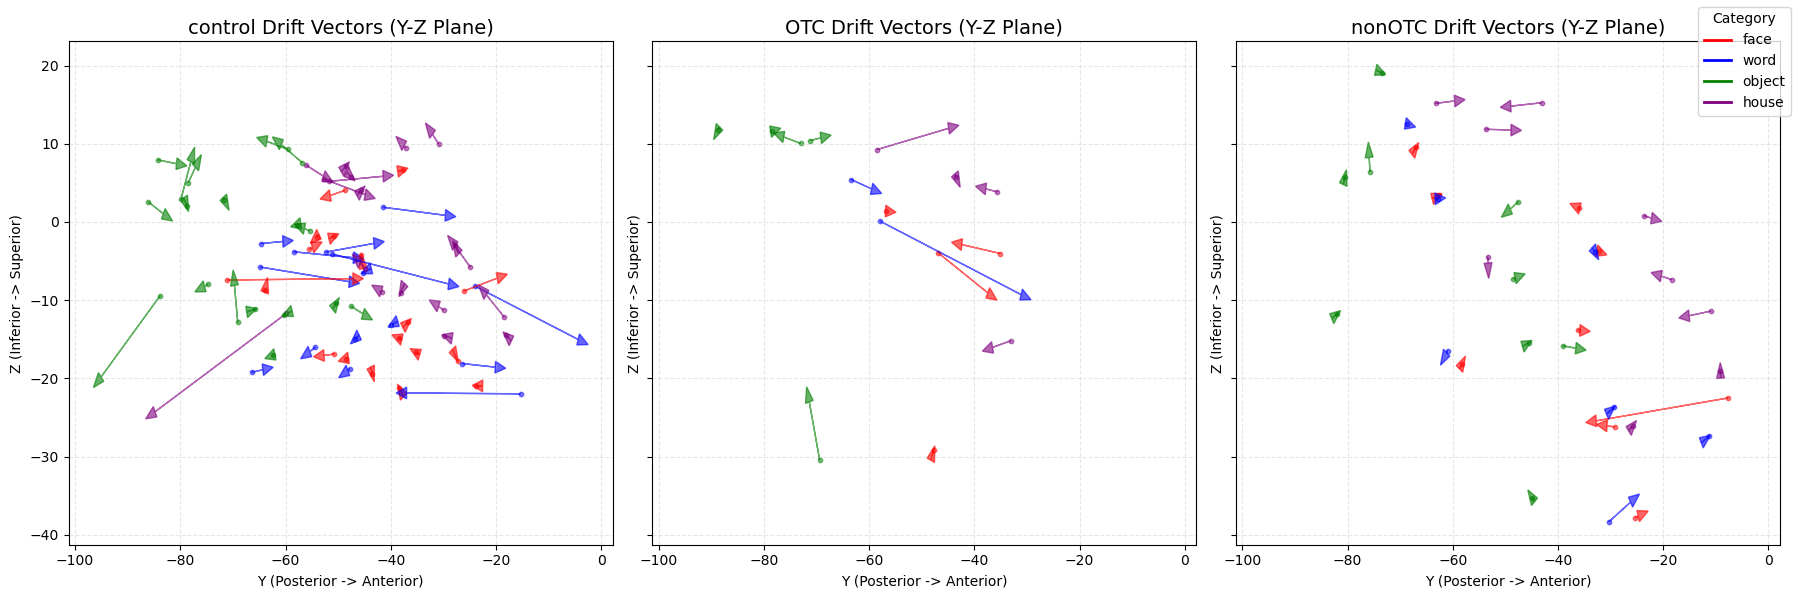

In [20]:
# CELL 13: Quiver Plot of ROI Drift
import matplotlib.pyplot as plt
import seaborn as sns

def plot_drift_quiver(results_dict, subjects_dict):
    # Setup
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    groups = ['control', 'OTC', 'nonOTC']
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    # Store vectors for summary
    vectors = []

    print("Generating Quiver Plots...")
    
    for ax, target_group in zip(axes, groups):
        ax.set_title(f"{target_group} Drift Vectors (Y-Z Plane)", fontsize=14)
        ax.set_xlabel("Y (Posterior -> Anterior)")
        ax.set_ylabel("Z (Inferior -> Superior)")
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Plot Arrows
        for sid, rois in results_dict.items():
            info = subjects_dict.get(sid, {})
            
            # Group check
            g = info.get('group', 'control')
            if info.get('patient_status') == 'control': g = 'control'
            if g != target_group: continue
            
            for roi_key, sessions in rois.items():
                cat = roi_key.split('_')[1]
                hemi = roi_key.split('_')[0]
                col = colors.get(cat, 'gray')
                
                # Check weak signal flag (simulate the exclusion we discussed)
                # (You can implement the actual flag check if you stored it in the dict)
                # For now, we rely on the fact that 'results_dict' has the data
                
                sorted_ses = sorted(sessions.keys())
                if len(sorted_ses) < 2: continue
                
                # Get Coords
                c1 = sessions[sorted_ses[0]]['centroid']
                c2 = sessions[sorted_ses[-1]]['centroid']
                
                # Check for weak signal thresholds and SKIP if weak
                t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
                t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
                if t1 < 1.65 or t2 < 1.65: continue
                
                # Plot Arrow (Y and Z coordinates usually capture the ventral stream shift best)
                # Y is usually index 1, Z is index 2 in MNI-ish space
                # Check your coordinate system! usually: x=L/R, y=P/A, z=I/S
                
                y1, z1 = c1[1], c1[2]
                y2, z2 = c2[1], c2[2]
                
                # Draw arrow
                ax.arrow(y1, z1, (y2-y1), (z2-z1), 
                         head_width=1.5, head_length=2, fc=col, ec=col, alpha=0.6, length_includes_head=True)
                
                # Add dot at start
                ax.scatter(y1, z1, c=col, s=10, alpha=0.5)

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=c, lw=2) for c in colors.values()]
    fig.legend(custom_lines, colors.keys(), loc='upper right', title="Category")
    
    plt.tight_layout()
    plt.show()

plot_drift_quiver(golarai_dynamic, ANALYSIS_SUBJECTS)

In [21]:
# Check which specific ROIs were flagged as WEAK_SIGNAL
weak_rois = df_diag[df_diag['flag'] == 'WEAK_SIGNAL'][['subject', 'group', 'roi', 'thresh_T1', 'thresh_T2']]
print("--- THE 10 EXCLUDED ROIs ---")
print(weak_rois.to_string(index=False))

# Check the category breakdown
print("\n--- BREAKDOWN BY CATEGORY ---")
print(weak_rois['roi'].apply(lambda x: x.split('_')[1]).value_counts())

--- THE 10 EXCLUDED ROIs ---
subject   group     roi  thresh_T1  thresh_T2
sub-004     OTC  l_word       1.64       2.20
sub-007  nonOTC  r_word       1.64       1.79
sub-008     OTC  l_word       1.64       1.81
sub-010     OTC  r_face       1.96       1.64
sub-010     OTC  r_word       2.24       1.64
sub-010     OTC r_house       1.64       1.64
sub-081  nonOTC  r_word       1.64       1.64
sub-027 control  r_word       2.37       1.64
sub-058 control  r_word       1.81       1.64
sub-062 control  r_word       1.71       1.64

--- BREAKDOWN BY CATEGORY ---
word     8
face     1
house    1
Name: roi, dtype: int64


In [22]:
# CELL 14: Full Data Printout
import pandas as pd

# 1. Configure Pandas to show EVERYTHING (no truncation)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 2)

# 2. Print the 10 Excluded "Weak Signal" ROIs
print("======================================================================")
print("                       THE 10 EXCLUDED ROIS")
print("           (Reason: Top 20% Peak Z < 1.65 at T1 or T2)")
print("======================================================================")
weak_rois = df_diag[df_diag['flag'] == 'WEAK_SIGNAL'].sort_values(['group', 'subject'])
print(weak_rois[['subject', 'group', 'roi', 'thresh_T1', 'thresh_T2', 'drift_mm']].to_string(index=False))

print("\n\n")

# 3. Print the VALID Data (The ROIs used in your Quiver Plot & RDM)
print("======================================================================")
print("                       VALID DATA (INCLUDED)")
print("                 (Top 20% Peak Z >= 1.65 at T1 & T2)")
print("======================================================================")
valid_data = df_diag[df_diag['flag'] == ''].sort_values(['group', 'subject', 'roi'])
print(valid_data[['subject', 'group', 'roi', 'n_sessions', 'thresh_T1', 'thresh_T2', 'drift_mm']].to_string(index=False))

# 4. Quick Summary Stats on the VALID data
print("\n\n")
print("======================================================================")
print("                     SUMMARY STATS (VALID DATA ONLY)")
print("======================================================================")
print(valid_data.groupby('group')['drift_mm'].describe()[['count', 'mean', 'std', 'max']])

                       THE 10 EXCLUDED ROIS
           (Reason: Top 20% Peak Z < 1.65 at T1 or T2)
subject  group    roi    thresh_T1  thresh_T2  drift_mm
sub-004     OTC  l_word    1.64       2.20       18.8  
sub-008     OTC  l_word    1.64       1.81       54.2  
sub-010     OTC  r_face    1.96       1.64       11.0  
sub-010     OTC  r_word    2.24       1.64       20.0  
sub-010     OTC r_house    1.64       1.64       19.0  
sub-027 control  r_word    2.37       1.64        4.8  
sub-058 control  r_word    1.81       1.64        9.4  
sub-062 control  r_word    1.71       1.64        2.0  
sub-007  nonOTC  r_word    1.64       1.79       28.9  
sub-081  nonOTC  r_word    1.64       1.64       35.1  



                       VALID DATA (INCLUDED)
                 (Top 20% Peak Z >= 1.65 at T1 & T2)
subject  group    roi     n_sessions  thresh_T1  thresh_T2  drift_mm
sub-004     OTC   l_face      5         1.66       4.32        9.5  
sub-004     OTC  l_house      5         1.84  

Generating Rose Plots (Centered Vectors)...


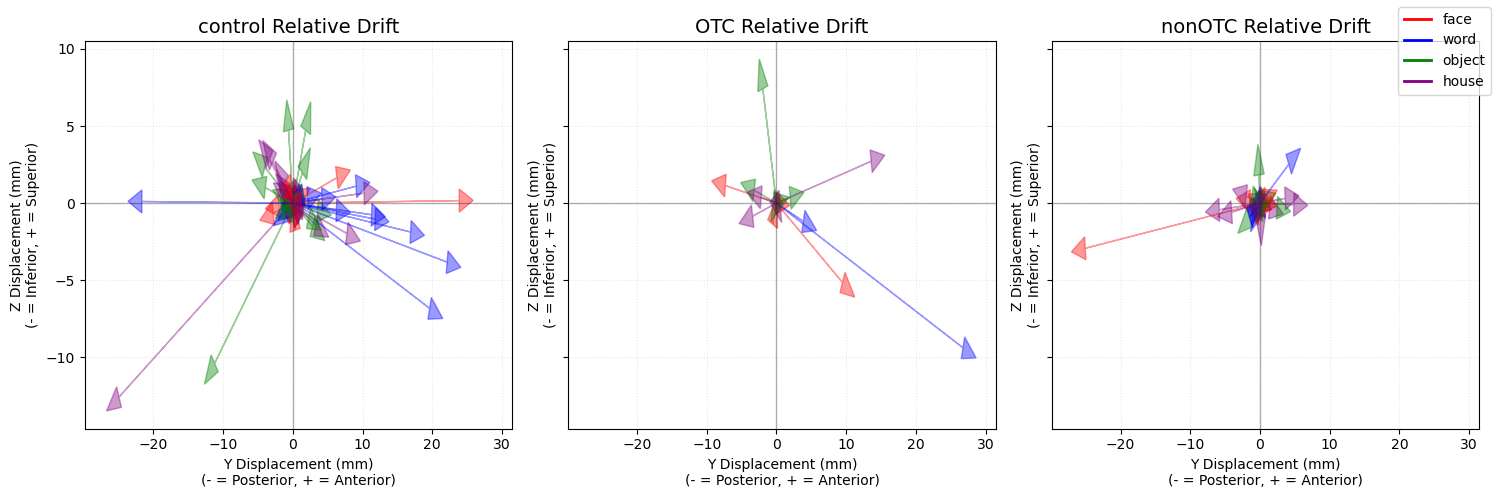

In [23]:
# CELL 15: "Rose Plot" (Relative Drift Vectors)
import matplotlib.pyplot as plt

def plot_drift_rose(results_dict, subjects_dict):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    groups = ['control', 'OTC', 'nonOTC']
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    print("Generating Rose Plots (Centered Vectors)...")
    
    for ax, target_group in zip(axes, groups):
        ax.set_title(f"{target_group} Relative Drift", fontsize=14)
        ax.set_xlabel("Y Displacement (mm)\n(- = Posterior, + = Anterior)")
        ax.set_ylabel("Z Displacement (mm)\n(- = Inferior, + = Superior)")
        ax.axhline(0, color='black', linewidth=1, alpha=0.3)
        ax.axvline(0, color='black', linewidth=1, alpha=0.3)
        ax.grid(True, linestyle=':', alpha=0.3)
        
        # Plot Arrows
        for sid, rois in results_dict.items():
            info = subjects_dict.get(sid, {})
            
            # Group filtering
            g = info.get('group', 'control')
            if info.get('patient_status') == 'control': g = 'control'
            if g != target_group: continue
            
            for roi_key, sessions in rois.items():
                cat = roi_key.split('_')[1]
                col = colors.get(cat, 'gray')
                
                sorted_ses = sorted(sessions.keys())
                if len(sorted_ses) < 2: continue
                
                # Check thresholds
                t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
                t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
                if t1 < 1.65 or t2 < 1.65: continue
                
                # Get Coordinates
                c1 = sessions[sorted_ses[0]].get('centroid')
                c2 = sessions[sorted_ses[-1]].get('centroid')
                
                # CALCULATE RELATIVE VECTOR (Normalize Start to 0,0)
                dy = c2[1] - c1[1]
                dz = c2[2] - c1[2]
                
                # Plot arrow starting from (0,0)
                ax.arrow(0, 0, dy, dz, 
                         head_width=1.5, head_length=2, fc=col, ec=col, alpha=0.4, length_includes_head=True)

    # Legend
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=c, lw=2) for c in colors.values()]
    fig.legend(custom_lines, colors.keys(), loc='upper right')
    
    plt.tight_layout()
    plt.show()

plot_drift_rose(golarai_dynamic, ANALYSIS_SUBJECTS)

Generating Polar Rose Plots...


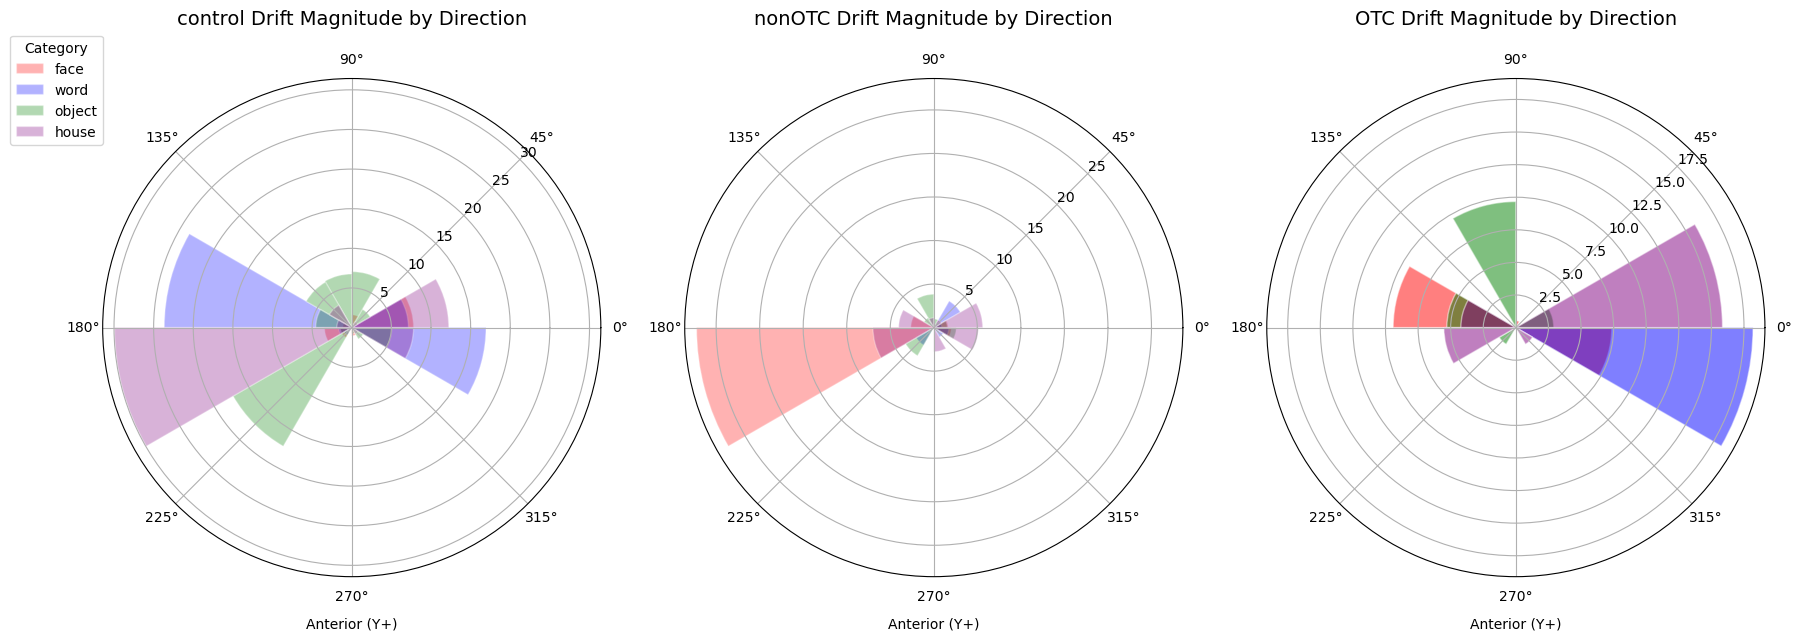

In [26]:
# CELL 18: Standard Polar Bar Plot (Rose Plot)
import numpy as np
import matplotlib.pyplot as plt

def plot_polar_rose(results_dict, subjects_dict):
    # --- Configuration ---
    # 12 bins = 30-degree slices (Standard clock-face style)
    N_BINS = 12 
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (2 * np.pi) / N_BINS  # Uniform width for all bars
    
    # Categories and Colors
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    
    # Setup Figure
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})
    groups = ['control', 'nonOTC', 'OTC']
    
    # Helper to convert Y,Z to Angle,Radius
    def cart2pol(y, z):
        radius = np.sqrt(y**2 + z**2)
        angle = np.arctan2(z, y) # Returns -pi to pi
        return angle, radius

    print("Generating Polar Rose Plots...")

    for ax, group in zip(axes, groups):
        ax.set_title(f"{group} Drift Magnitude by Direction", fontsize=14, pad=20)
        
        # Grid Setup
        ax.set_theta_zero_location("E") # 0 degrees = East (Anterior if Y-axis is horizontal)
        ax.set_theta_direction(1)       # Counter-clockwise
        
        # Collect all vectors for this group
        group_vectors = {'face': [], 'word': [], 'object': [], 'house': []}
        
        for sid, rois in results_dict.items():
            info = subjects_dict.get(sid, {})
            g = info.get('group', 'control')
            if info.get('patient_status') == 'control': g = 'control'
            if g != group: continue
            
            for roi_key, sessions in rois.items():
                cat = roi_key.split('_')[1]
                sorted_ses = sorted(sessions.keys())
                if len(sorted_ses) < 2: continue
                
                # Check Thresholds (Exclude Weak Signal)
                t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
                t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
                if t1 < 1.65 or t2 < 1.65: continue
                
                # Calculate Vector
                c1 = sessions[sorted_ses[0]]['centroid']
                c2 = sessions[sorted_ses[-1]]['centroid']
                
                # Y (Posterior-Anterior) is usually axis 1, Z (Inferior-Superior) is axis 2
                dy = c2[1] - c1[1]
                dz = c2[2] - c1[2]
                
                angle, radius = cart2pol(dy, dz)
                group_vectors[cat].append((angle, radius))
        
        # Plotting Strategy
        # We plot stacked bars or overlaid bars. 
        # For clarity in this dense data, let's plot "Max Magnitude" in each bin per category
        
        # Initialize max radius per bin for scaling
        max_r_plot = 0
        
        for cat, vec_list in group_vectors.items():
            if not vec_list: continue
            
            angles = [v[0] for v in vec_list]
            radii = [v[1] for v in vec_list]
            
            # Digitize angles to find which bin they belong to
            bin_indices = np.digitize(angles, bin_edges) - 1
            
            # For each bin, calculate the MEAN magnitude of drift in that direction
            # (You could also use SUM or MAX depending on what story you want to tell)
            bin_values = np.zeros(N_BINS)
            for i in range(N_BINS):
                # Find all drifts that point in this direction
                indices = np.where(bin_indices == i)[0]
                if len(indices) > 0:
                    # Taking the MEAN drift distance of vectors in this bin
                    bin_values[i] = np.mean(np.array(radii)[indices])
            
            # Plot bars
            # Alpha is lower for OTC to see overlaps if multiple categories invade same space
            alpha = 0.5 if group == 'OTC' else 0.3 
            bars = ax.bar(bin_centers, bin_values, width=width, bottom=0.0, 
                          color=colors[cat], alpha=alpha, label=cat, edgecolor='white')
            
            if len(bin_values) > 0:
                max_r_plot = max(max_r_plot, np.max(bin_values))

        # Add custom labels to the grid
        ax.set_rlabel_position(45)
        ax.set_xlabel("Anterior (Y+)", labelpad=10)
        # Fix the radial limit so plots are comparable
        # ax.set_ylim(0, 20) # Uncomment to force same scale (e.g., 20mm)
        
        if group == 'control':
            ax.legend(loc='upper left', bbox_to_anchor=(-0.2, 1.1), title="Category")

    plt.tight_layout()
    plt.show()

plot_polar_rose(golarai_dynamic, ANALYSIS_SUBJECTS)

Processing vectors for combined rose plot...


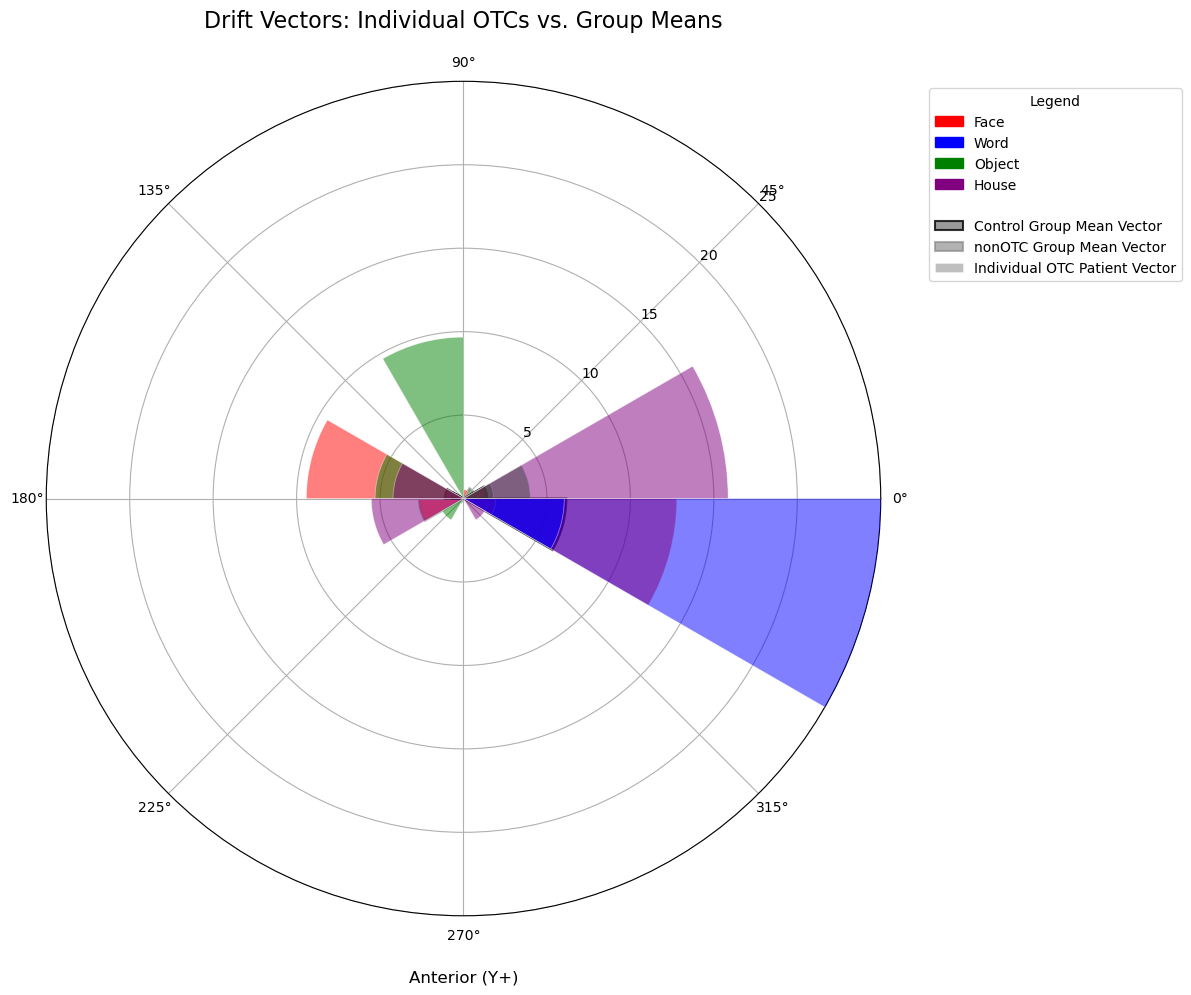

In [27]:
# CELL 19: Combined Rose Plot (Group Means + Individual OTCs)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

def plot_combined_rose(results_dict, subjects_dict):
    # --- Configuration ---
    N_BINS = 12 # 30-degree slices
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (2 * np.pi) / N_BINS
    
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    categories = ['face', 'word', 'object', 'house']
    
    # Helper: Cartesian to Polar
    def cart2pol(y, z):
        radius = np.sqrt(y**2 + z**2)
        angle = np.arctan2(z, y)
        return angle, radius

    # Helper: Find bin index for an angle
    def get_bin_index(angle):
        # digitize returns 1-based index, subtract 1 for 0-based
        # handle edge case where angle is exactly pi
        idx = np.digitize(angle, bin_edges) - 1
        return min(idx, N_BINS - 1)

    # --- Harvest Data ---
    # Store all valid vectors (dy, dz) by group and category
    data_storage = {g: {c: [] for c in categories} for g in ['control', 'nonOTC', 'OTC']}
    
    print("Processing vectors for combined rose plot...")
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        g = info.get('group', 'control')
        if info.get('patient_status') == 'control': g = 'control'
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: continue
            
            # Weak Signal Exclusion (Crucial step)
            t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
            t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
            if t1 < 1.65 or t2 < 1.65: continue
            
            c1 = sessions[sorted_ses[0]]['centroid']
            c2 = sessions[sorted_ses[-1]]['centroid']
            dy = c2[1] - c1[1]
            dz = c2[2] - c1[2]
            
            data_storage[g][cat].append((dy, dz))

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': 'polar'})
    ax.set_title("Drift Vectors: Individual OTCs vs. Group Means", fontsize=16, pad=20)
    
    # Setup Grid
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20, fontsize=12)
    # Set a fixed limit to make comparisons easy (e.g., 25mm)
    ax.set_ylim(0, 25) 

    # 1. Plot Group Means (Control & nonOTC) - THICK BARS in Background
    for group in ['control', 'nonOTC']:
        # Slightly different styles to distinguish the two baseline groups
        alpha = 0.8 if group == 'control' else 0.6
        edge = 'black' if group == 'control' else 'gray'
        zord = 2 if group == 'control' else 1
        
        for cat in categories:
            vecs = data_storage[group][cat]
            if not vecs: continue
            
            # Calculate Mean Vector
            mean_dy = np.mean([v[0] for v in vecs])
            mean_dz = np.mean([v[1] for v in vecs])
            
            # Convert to Polar
            angle, radius = cart2pol(mean_dy, mean_dz)
            bin_idx = get_bin_index(angle)
            
            # Plot ONE thick bar for the mean
            ax.bar(bin_centers[bin_idx], radius, width=width, bottom=0.0,
                   color=colors[cat], alpha=alpha, edgecolor=edge, linewidth=1.5, zorder=zord)

    # 2. Plot Individual OTCs - THIN BARS in Foreground
    for cat in categories:
        vecs = data_storage['OTC'][cat]
        if not vecs: continue
        
        for dy, dz in vecs:
            angle, radius = cart2pol(dy, dz)
            bin_idx = get_bin_index(angle)
            
            # Plot individual thin bar
            # Higher zorder puts them on top
            # Lower alpha lets overlaps show density
            ax.bar(bin_centers[bin_idx], radius, width=width, bottom=0.0,
                   color=colors[cat], alpha=0.5, edgecolor='white', linewidth=0.5, zorder=10)

    # --- Custom Legend ---
    # Category Colors
    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in colors.items()]
    
    # Style definitions
    legend_styles = [
        mpatches.Patch(facecolor='gray', edgecolor='black', linewidth=1.5, alpha=0.8, label='Control Group Mean Vector'),
        mpatches.Patch(facecolor='gray', edgecolor='gray', linewidth=1.5, alpha=0.6, label='nonOTC Group Mean Vector'),
        mpatches.Patch(facecolor='gray', edgecolor='white', linewidth=0.5, alpha=0.5, label='Individual OTC Patient Vector'),
    ]
    
    # Combine and place legend outside to save space
    full_legend = legend_cats + [Line2D([0],[0],linestyle='none')] + legend_styles
    ax.legend(handles=full_legend, loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")
    
    plt.tight_layout()
    plt.show()

plot_combined_rose(golarai_dynamic, ANALYSIS_SUBJECTS)

In [34]:
# CELL 25: Explicit Data Audit for OTC
import pandas as pd
import numpy as np

def audit_otc_data(results_dict, subjects_dict):
    audit_data = []
    
    print("--- OTC DATA AUDIT ---")
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        # Filter for OTC only
        if info.get('group') != 'OTC' or info.get('patient_status') == 'control': 
            continue
            
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            hemi = roi_key.split('_')[0]
            sorted_ses = sorted(sessions.keys())
            
            if len(sorted_ses) < 2:
                status = "EXCLUDED (Only 1 Session)"
                drift = np.nan
                t1, t2 = np.nan, np.nan
            else:
                # Get Stats
                s1 = sessions[sorted_ses[0]]
                s2 = sessions[sorted_ses[-1]]
                t1 = s1.get('used_thresh', 0)
                t2 = s2.get('used_thresh', 0)
                
                c1 = s1['centroid']
                c2 = s2['centroid']
                dy = c2[1] - c1[1]
                dz = c2[2] - c1[2]
                drift = np.sqrt(dy**2 + dz**2) # Magnitude
                
                # Determine Status
                if t1 < 1.65 or t2 < 1.65:
                    status = "EXCLUDED (Weak Signal)"
                else:
                    status = "INCLUDED"
            
            audit_data.append({
                'Subject': sid,
                'ROI': f"{hemi}_{cat}",
                'Cat': cat,
                'T1_Z': round(t1, 2) if not np.isnan(t1) else '-',
                'T2_Z': round(t2, 2) if not np.isnan(t2) else '-',
                'Drift_mm': round(drift, 1) if not np.isnan(drift) else '-',
                'Status': status
            })

    # Create DataFrame and Sort
    df_audit = pd.DataFrame(audit_data)
    # Sort by Category then Status to group them clearly
    df_audit = df_audit.sort_values(['Cat', 'Status', 'Subject'])
    
    # Print by Category
    for cat in ['face', 'word', 'object', 'house']:
        print(f"\n=== CATEGORY: {cat.upper()} ===")
        subset = df_audit[df_audit['Cat'] == cat]
        print(subset[['Subject', 'ROI', 'T1_Z', 'T2_Z', 'Drift_mm', 'Status']].to_string(index=False))
        
        # Summary Count
        valid_count = len(subset[subset['Status'] == 'INCLUDED'])
        print(f"Total Valid for Plot: {valid_count}")

audit_otc_data(golarai_dynamic, ANALYSIS_SUBJECTS)

--- OTC DATA AUDIT ---

=== CATEGORY: FACE ===
Subject  ROI    T1_Z  T2_Z  Drift_mm         Status        
sub-010 r_face  1.96  1.64     9.6   EXCLUDED (Weak Signal)
sub-004 l_face  1.66  4.32     9.4                 INCLUDED
sub-008 l_face  7.75  6.01     0.5                 INCLUDED
sub-017 r_face  2.83  3.15    12.8                 INCLUDED
sub-021 r_face  7.71  7.68     1.9                 INCLUDED
Total Valid for Plot: 4

=== CATEGORY: WORD ===
Subject  ROI    T1_Z  T2_Z  Drift_mm         Status        
sub-004 l_word  1.64  2.20    18.6   EXCLUDED (Weak Signal)
sub-008 l_word  1.64  1.81    54.2   EXCLUDED (Weak Signal)
sub-010 r_word  2.24  1.64    20.0   EXCLUDED (Weak Signal)
sub-017 r_word  2.40  2.52    30.4                 INCLUDED
sub-021 r_word  2.23  4.30     6.0                 INCLUDED
Total Valid for Plot: 2

=== CATEGORY: OBJECT ===
Subject   ROI     T1_Z  T2_Z  Drift_mm  Status 
sub-004 l_object  2.88  5.51    4.0    INCLUDED
sub-008 l_object  5.79  2.31    9.7    

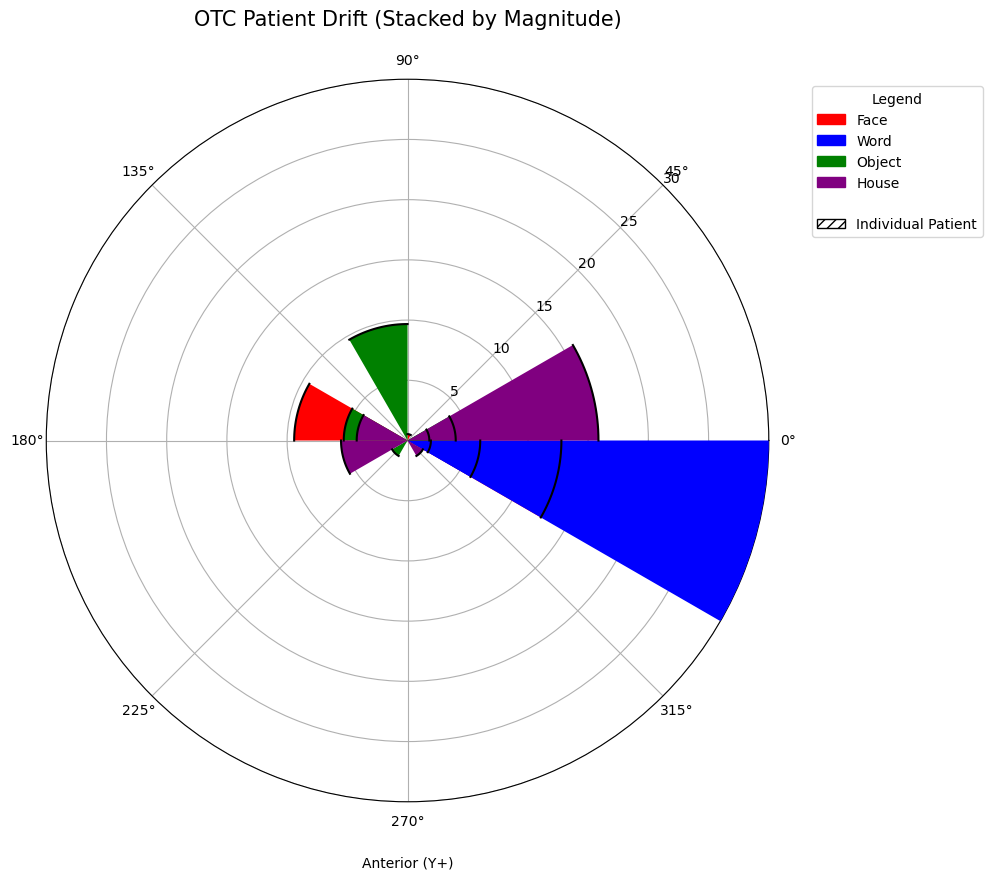

In [35]:
# CELL 26: Top-Cap Rose Plot (Cleaner Visuals)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_otc_rose_top_cap(results_dict, subjects_dict):
    # --- Configuration ---
    N_BINS = 12
    # Create bin edges (standard -pi to pi)
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (2 * np.pi) / N_BINS
    
    colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    categories = ['face', 'word', 'object', 'house']
    
    # Helper: Cartesian to Polar
    def cart2pol(y, z):
        return np.arctan2(z, y), np.sqrt(y**2 + z**2)
    
    def get_bin_index(angle):
        return min(np.digitize(angle, bin_edges) - 1, N_BINS - 1)

    # --- Harvest Data ---
    otc_data = {c: [] for c in categories}
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        if info.get('group') != 'OTC' or info.get('patient_status') == 'control': continue
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: continue
            
            # Threshold Check
            t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
            t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
            if t1 < 1.65 or t2 < 1.65: continue
            
            c1 = sessions[sorted_ses[0]]['centroid']
            c2 = sessions[sorted_ses[-1]]['centroid']
            dy, dz = c2[1] - c1[1], c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            otc_data[cat].append({
                'bin_idx': get_bin_index(angle),
                'radius': radius,
                'sid': sid
            })

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_title("OTC Patient Drift (Stacked by Magnitude)", fontsize=15, pad=20)
    
    # Grid Setup
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 30) # Fixed scale (adjust if you have drifts > 30mm)

    # Plot Logic
    for cat in categories:
        bars = otc_data[cat]
        if not bars: continue
        
        # Sort Largest to Smallest
        # This ensures big bars are drawn first, and small bars sit on top
        bars.sort(key=lambda x: x['radius'], reverse=True)
        
        for bar in bars:
            center = bin_centers[bar['bin_idx']]
            radius = bar['radius']
            
            # 1. Draw the Solid Bar (No Outline)
            ax.bar(center, radius, width=width, bottom=0.0,
                   color=colors[cat], alpha=1.0, edgecolor='none', 
                   hatch='///', zorder=10)
            
            # 2. Draw the "Top Cap" (Black Arc)
            # Create an arc of points at this radius spanning the bin width
            theta = np.linspace(center - width/2, center + width/2, 20)
            r = np.full_like(theta, radius)
            ax.plot(theta, r, color='black', linewidth=1.5, zorder=11)

    # --- Custom Legend ---
    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in colors.items()]
    texture_note = [mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Individual Patient')]
    
    full_legend = legend_cats + [mpatches.Patch(visible=False)] + texture_note
    ax.legend(handles=full_legend, loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")

    plt.tight_layout()
    plt.show()

plot_otc_rose_top_cap(golarai_dynamic, ANALYSIS_SUBJECTS)

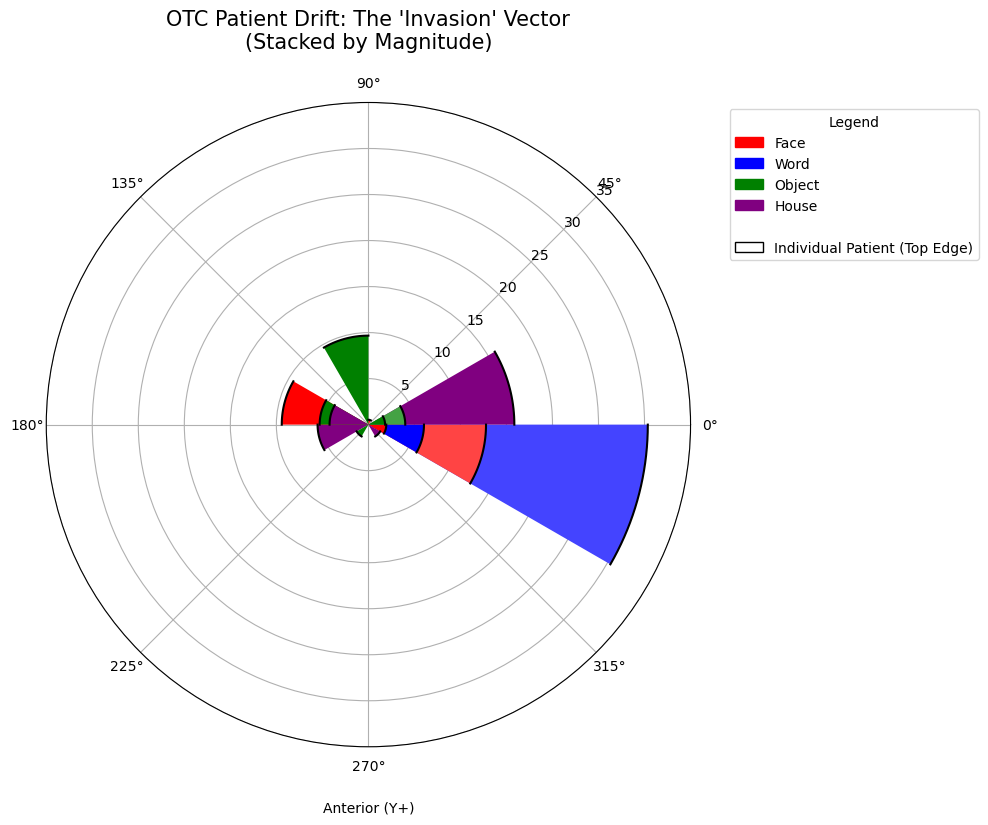

In [36]:
# CELL 27: The Telescope Rose Plot (Sorted, Solid, No Mixing)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

def plot_telescope_rose(results_dict, subjects_dict):
    # --- Configuration ---
    N_BINS = 12
    bin_edges = np.linspace(-np.pi, np.pi, N_BINS + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    width = (2 * np.pi) / N_BINS
    
    # Base Colors
    base_colors = {'face': 'red', 'word': 'blue', 'object': 'green', 'house': 'purple'}
    categories = ['face', 'word', 'object', 'house']
    
    # Helper: Tint Generator (Make color lighter)
    def get_tint(color_name, level, max_levels):
        # Level 0 = Darkest (Base), Higher levels = Lighter
        base_rgb = mcolors.to_rgb(color_name)
        # Mix with white based on level
        white_amt = min(0.6, (level / (max_levels + 1)) * 0.8) if max_levels > 0 else 0
        return tuple(c + (1 - c) * white_amt for c in base_rgb)

    # Helper: Cartesian to Polar
    def cart2pol(y, z):
        return np.arctan2(z, y), np.sqrt(y**2 + z**2)
    
    def get_bin_index(angle):
        return min(np.digitize(angle, bin_edges) - 1, N_BINS - 1)

    # --- Harvest & Organize Data ---
    # Structure: bins[bin_index] = list of {radius, cat, sid}
    bins = {i: [] for i in range(N_BINS)}
    
    for sid, rois in results_dict.items():
        info = subjects_dict.get(sid, {})
        if info.get('group') != 'OTC' or info.get('patient_status') == 'control': continue
        
        for roi_key, sessions in rois.items():
            cat = roi_key.split('_')[1]
            sorted_ses = sorted(sessions.keys())
            if len(sorted_ses) < 2: continue
            
            # Threshold Check
            t1 = sessions[sorted_ses[0]].get('used_thresh', 0)
            t2 = sessions[sorted_ses[-1]].get('used_thresh', 0)
            if t1 < 1.65 or t2 < 1.65: continue
            
            c1 = sessions[sorted_ses[0]]['centroid']
            c2 = sessions[sorted_ses[-1]]['centroid']
            dy, dz = c2[1] - c1[1], c2[2] - c1[2]
            
            angle, radius = cart2pol(dy, dz)
            b_idx = get_bin_index(angle)
            bins[b_idx].append({'radius': radius, 'cat': cat, 'sid': sid})

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_title("OTC Patient Drift: The 'Invasion' Vector\n(Stacked by Magnitude)", fontsize=15, pad=20)
    
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    ax.set_rlabel_position(45)
    ax.set_xlabel("Anterior (Y+)", labelpad=20)
    ax.set_ylim(0, 35) # Validated range based on audit (max drift ~30.4mm)

    # Draw Logic per Bin
    for b_idx, items in bins.items():
        if not items: continue
        
        # 1. SORT GLOBALLY by Radius (Largest First)
        # This ensures the biggest bar is the background, smallest is foreground
        items.sort(key=lambda x: x['radius'], reverse=True)
        
        # Track counts per category in this bin to assign tints
        cat_counts = {c: 0 for c in categories}
        cat_totals = {c: sum(1 for x in items if x['cat'] == c) for c in categories}
        
        for item in items:
            cat = item['cat']
            radius = item['radius']
            center = bin_centers[b_idx]
            
            # Calculate Tint
            # If there are 3 Faces in this bin, the first one (Largest) gets lightest tint?
            # Or Largest = Base Color? 
            # Let's do: Smallest = Darkest (Base), Largest = Lightest.
            # Since we iterate Large -> Small, we assign tints: Light -> Dark
            
            # Index 0 (Largest) -> High Tint (Light)
            # Index N (Smallest) -> Low Tint (Dark)
            
            # Current count for this cat (0 to Total-1)
            current_rank = cat_counts[cat]
            total_in_cat = cat_totals[cat]
            
            # We want the LAST item (Smallest) to be base color (level 0)
            # We want the FIRST item (Largest) to be lighter (level N)
            # Rank 0 (Largest) -> Level = Total - 1
            tint_level = (total_in_cat - 1) - current_rank
            
            color = get_tint(base_colors[cat], tint_level, total_in_cat)
            
            # Plot Bar
            # Zorder ensures correct stacking order implicitly by loop order, 
            # but explicit descending radius works naturally.
            ax.bar(center, radius, width=width, bottom=0.0,
                   color=color, alpha=1.0, edgecolor='none', zorder=10)
            
            # Draw Top Cap (Black Arc)
            theta = np.linspace(center - width/2, center + width/2, 20)
            r = np.full_like(theta, radius)
            ax.plot(theta, r, color='black', linewidth=1.5, zorder=11)
            
            cat_counts[cat] += 1

    # --- Custom Legend ---
    legend_cats = [mpatches.Patch(color=c, label=cat.title()) for cat, c in base_colors.items()]
    note = mpatches.Patch(facecolor='white', edgecolor='black', label='Individual Patient (Top Edge)')
    
    full_legend = legend_cats + [mpatches.Patch(visible=False)] + [note]
    ax.legend(handles=full_legend, loc='upper left', bbox_to_anchor=(1.05, 1), title="Legend")

    plt.tight_layout()
    plt.show()

plot_telescope_rose(golarai_dynamic, ANALYSIS_SUBJECTS)